In [1]:
import sys
import torch
from numpy import unravel_index as unravel
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
import sys
import torch
from numpy import unravel_index as unravel
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

action_dict = {'a': torch.tensor([0., -1.]), 'd': torch.tensor([0., 1.]), 'w': torch.tensor([-1., 0.]), 's': torch.tensor([1., 0.])}

def do(snake: torch.Tensor, action):
    reward = 0
    positions = snake.flatten().topk(2)[1]
    [pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
    #print('direction', (pos_cur - pos_prev)) # Направление движения
    pos_next = (pos_cur + action) % torch.Tensor([snake.shape]).squeeze(0) 
    
    pos_cur = pos_cur.int()
    pos_next = pos_next.int()
    
    # Проверка на столкновение
    if (snake[tuple(pos_next)] > 0).any():
        reward = -100
        return reward,(snake[tuple(pos_cur)] - 2).item()  # Возвращаем счёт (длина змейки минус 2)
    
    # Кушаем яблоко
    if snake[tuple(pos_next)] == -1:
        pos_food = (snake == 0).flatten().to(torch.float).multinomial(1)[0] # Генерируем позицию яблока
        snake[unravel(pos_food, snake.shape)] = -1 # Добавляем яблоко в игру
        reward= 10
        
    else: # Двигаемся в пустую клетку
        snake[snake > 0] -= 1  # Устанавливаем все значения в теле змеи равными 1

    snake[tuple(pos_next)] = snake[tuple(pos_cur)] + 1 # перемещаем голову
    return reward, (snake[tuple(pos_cur)] - 2).item()


In [3]:
class Neuro_BigBoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3, 32, kernel_size=(3,3), padding = 1)
        self.conv1=nn.Conv2d(32, 64, kernel_size=(3,3), padding = 1)
        self.fl = nn.Flatten()
        self.fc1=nn.Linear(64*32*32, 32)
        self.fc2=nn.Linear(32,4)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x= F.relu(self.conv2(x))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = self.fc1(x)

In [4]:
class Champion():
    def __init__(self):
        super().__init__()
        self.n_games = 0
        self.model = Neuro_BigBoss().cuda()
        self.eps = 0

    def get_state(self, snake):
        some_shit=1

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


In [57]:

plt.rcParams['figure.figsize'] = 10, 10
snake = torch.zeros((32, 32), dtype=torch.int)
snake[0, :3] = torch.Tensor([1, 2, -1]) # [хвост, голова, яблоко]

tensor(4, dtype=torch.int32)
tensor(5)
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
1


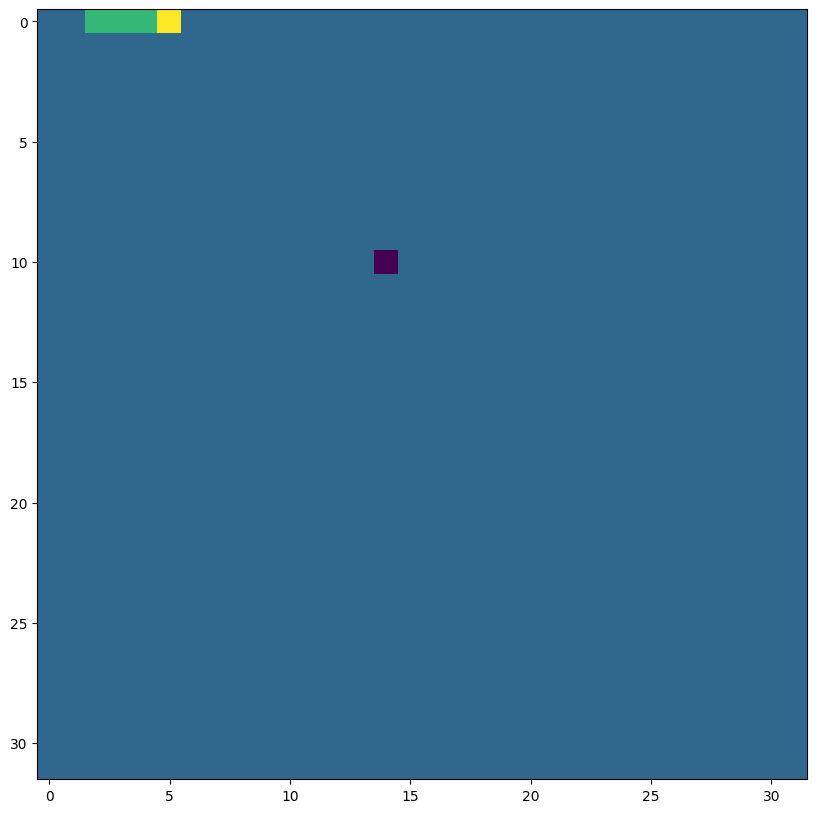

In [101]:
fig, ax = plt.subplots(1, 1)
a = torch.zeros(snake.shape)
positions = snake.flatten().topk(2)[1]
[pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
a[snake>0]=1
a[snake==snake.max()]=2
print(snake.max())
print(snake.argmax())
a[snake<0]=-1
img = ax.imshow(a)
action = {'val': 1}
# print(a)
n = 0
score = None
while n<3:
    img.set_data(a)
    reward, score = do(snake, action_dict['d'])
    n += 1
print(a)
print(score)

In [14]:
img = ax.imshow(snake)